In [117]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class BitLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False, lora_rank=16):
        super(BitLinear, self).__init__(in_features, out_features, bias)
        self.gamma_forward = nn.Parameter(torch.randn(in_features), requires_grad=False)
        self.beta = nn.Parameter(torch.randn(out_features), requires_grad=False)
        self.epsilon = 1e-8

    def binarize(self, W):
        gamma = torch.sum(torch.abs(W)) / (W.shape[0] * W.shape[1])
        W = W / (gamma + self.epsilon)
        W_bin = torch.clamp(W, -1, 1).round()
        return W + (W_bin - W).detach()


    def forward(self, input):
        if input.dim() == 1:
            input = input.unsqueeze(0)

        input_norm = F.layer_norm(input, (self.in_features,))
        quant_scale = torch.max(torch.abs(input_norm), dim=1, keepdim=True).values
        input_quant = torch.sign(input_norm) * (quant_scale / self.gamma_forward)
        
        binary_weight = self.binarize(self.weight)

        output = torch.matmul(input_quant, binary_weight.t())
        output = output * self.beta.expand_as(output)

        return output

In [135]:
bitlayer = BitLinear(2500, 100)

#train the model to output the same input
train_loss = []
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bitlayer.parameters(), lr=0.001)
for i in range(1000):
    input = torch.randn(2500)
    output = bitlayer(input)
    loss = criterion(output, torch.ones(100))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(loss.item())
    


C:\Users\paulilioaica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


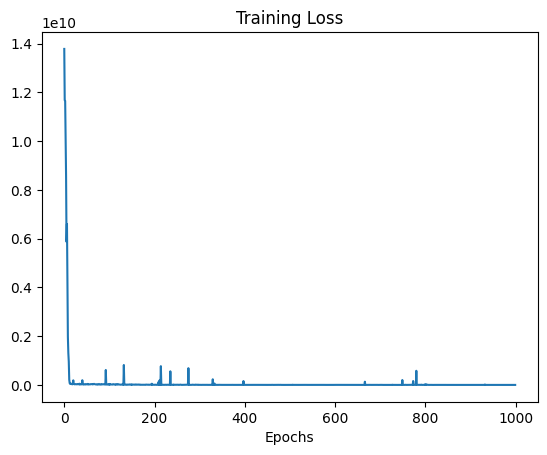

In [136]:
#print the loss

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.show()


In [144]:

from typing import Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional encoding definition

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        self.pe = torch.zeros(max_len, 1, d_model)
        self.pe[:, 0, 0::2] = torch.sin(position * div_term)
        self.pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.transpose(0, 1)
    def forward(self, x):
        self.pe = self.pe.to(x.device)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_hidden, num_heads, seq_len, d_k) -> None:
        super().__init__()
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        self.seq_len = seq_len
        self.d_k = d_k

        self.W_q = BitLinear(num_hidden, num_heads * num_hidden)
        self.W_k = BitLinear(num_hidden, num_heads * num_hidden)
        self.W_v = BitLinear(num_hidden, num_heads * num_hidden)
        self.W_o = BitLinear(num_heads * num_hidden, num_hidden)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.1)
        self.mask = self.get_mask(self.seq_len)
    
    def get_mask(self, size):
        device = next(self.parameters()).device
        mask = torch.triu(torch.ones(size, size, device=device), diagonal=1)  
        return mask.unsqueeze(0).unsqueeze(0)  

    def forward(self, query, key, values, dropout=0.1, mask=None):
        # Reshaping expanded to n_heads
        query = self.W_q(query).view(-1, self.num_heads, self.seq_len, self.num_hidden)
        key = self.W_k(key).view(-1, self.num_heads, self.seq_len, self.num_hidden)
        values = self.W_v(values).view(-1, self.num_heads, self.seq_len, self.num_hidden)

        # Q * K_T
        QK_T = torch.matmul(query,  key.mT)

        # QK_T / sqrt(dk)
        QK_T = QK_T / math.sqrt(self.d_k)

        if mask:
            self.mask = self.mask.to(query.device)
            QK_T = QK_T.masked_fill(self.mask == 1, float('-inf'))

        # softmax(QK_T / sqrt(d_k)
        attention_scores = self.softmax(QK_T)
        
        #dropout
        attention_scores = self.dropout(attention_scores)
        output = torch.matmul(attention_scores, values)  
        # Reshape and apply output linear layer  
        output = output.transpose(1, 2).contiguous().view(-1, self.seq_len, self.num_heads * self.num_hidden)  
        output = self.W_o(output)  
          
        return output  

# Feed forward definition
    
class FeedForward(nn.Module):
    def __init__(self, num_hidden, num_ffn_hidden) -> None:
        super().__init__()
        self.num_hidden = num_hidden
        self.num_ffn_hidden = num_ffn_hidden

        self.W_1 = BitLinear(num_hidden, num_ffn_hidden)
        self.W_2 = BitLinear(num_ffn_hidden, num_hidden)

    def forward(self, x):
        return self.W_2(F.relu(self.W_1(x)))


# Transformer definition

class TransformerEncoderLayer(nn.Module):
    def __init__(self, num_hidden, num_heads, seq_len) -> None:
        super().__init__()
        self.multihead_attention = MultiHeadAttention(num_hidden=num_hidden, num_heads=num_heads, seq_len=seq_len, d_k=1)
        self.feed_forward = FeedForward(num_hidden=num_hidden, num_ffn_hidden=2*num_hidden)
        self.layer_norm1 = nn.LayerNorm(num_hidden)
        self.layer_norm2 = nn.LayerNorm(num_hidden)
    
    def forward(self, input_with_pos):
        #attention 
        x = self.multihead_attention(input_with_pos, input_with_pos, input_with_pos)
        
        #add and norm
        x = x + input_with_pos
        x = self.layer_norm1(x)

        # add norm 
        x_final = self.feed_forward(x)
        x = x + x_final

        x = self.layer_norm2(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, n_heads, seq_len, num_hidden) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.decoders = nn.ModuleList([TransformerDecoderLayer(num_hidden, n_heads, seq_len) for i in range(num_layers)])

    def forward(self, x, encoder_output):
        for layer in self.decoders:
            x = layer(x, encoder_output)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, n_heads, seq_len, num_hidden) -> None:
        super().__init__()
        self.num_layers = num_layers
        self.encoders = nn.ModuleList([TransformerEncoderLayer(num_hidden, n_heads, seq_len) for i in range(num_layers)])
    def forward(self, x):
        for layer in self.encoders:
            x = layer(x)
        return x


class TransformerDecoderLayer(nn.Module):
    def __init__(self, num_hidden, num_heads, seq_len) -> None:
        super().__init__()
        self.multihead_attention_masked = MultiHeadAttention(num_hidden=num_hidden, num_heads=num_heads, seq_len=seq_len, d_k=1)
        self.multihead_attention = MultiHeadAttention(num_hidden=num_hidden, num_heads=num_heads, seq_len=seq_len, d_k=1)
        
        self.feed_forward = FeedForward(num_hidden=num_hidden, num_ffn_hidden=2*num_hidden)
        self.layer_norm1 = nn.LayerNorm(num_hidden)
        self.layer_norm2 = nn.LayerNorm(num_hidden)
        self.layer_norm3 = nn.LayerNorm(num_hidden)
    
    def forward(self, output_with_pos, encoder_output):
        # masked attention
        x = self.multihead_attention_masked(output_with_pos, output_with_pos, output_with_pos, mask=True)
        #add and norm
        x = x + output_with_pos
        x = self.layer_norm1(x)

        # attention
        x_attention = self.multihead_attention(encoder_output, encoder_output, x)

        #add and norm
        x = x + x_attention
        x = self.layer_norm2(x)

        #feed forward
        x_forward = self.feed_forward(x)

        #add and norm
        x = x + x_forward
        x = self.layer_norm3(x)
        return x

class Transformer(nn.Module):
    def __init__(self, encoder_layers_num, decoder_layers_num, num_hidden, num_heads, seq_len, vocab_size, embedding_dim) -> None:
        super().__init__()
        self.encoder = TransformerEncoder(encoder_layers_num, num_heads, seq_len, num_hidden)
        self.decoder = TransformerDecoder(decoder_layers_num, num_heads, seq_len, num_hidden)
        self.pos_enc = PositionalEncoding(embedding_dim, max_len=seq_len)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, y):
        #embeddings
        x = self.embedding(x)
        y = self.embedding(y)

        #pos encodings
        x = self.pos_enc(x)
        y = self.pos_enc(y)

        #forward pass
        enc_output = self.encoder(x)
        dec_output = self.decoder(y, enc_output)
        output = self.linear(dec_output)

        return output

In [145]:
model = Transformer(2, 2, 2500, 4, 128, 2000, 2048)

In [142]:
from tqdm import tqdm
#train the model to output the same input
train_loss = []
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i in tqdm(range(1000)):
    input = torch.randint(0, 2000, (128,))
    output = model(input, input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(loss.item())


RuntimeError: Given normalized_shape=[2500], expected input with shape [*, 2500], but got input of size[1, 128, 2048]